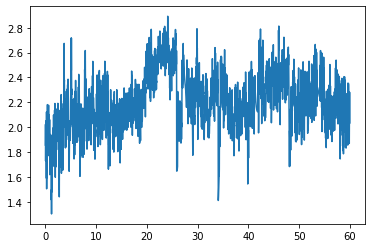

In [4]:
### Importing the necessary Python libraries and data needed for the calculations of the time lag

# Python lib import 
import csv
import PyQt5
import warnings
import scipy as sc
from scipy.stats import rankdata as rd
from scipy import optimize as op
import numpy as np
from numpy import errstate, isneginf
import matplotlib
import matplotlib.pyplot as plt
from math import log
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors

# Data import 
data=np.genfromtxt("../Example Data/TestTimeSignal.csv", delimiter=',')
df=pd.DataFrame(data)
data_interpolate=df.interpolate(limit_direction='both')
data1=pd.DataFrame.to_numpy(data_interpolate)
data2=data1.transpose()

t=np.array(np.linspace(0,60, num=2987))
t1=pd.DataFrame(t)
x=(data2[0])

plt.plot(t,x)
# Ignoring warnings printed to screen
warnings.filterwarnings("ignore")

In [5]:
eye_movement_data = pd.read_csv("../Example Data/TestTimeSignal.csv", header=None)
eye_movement_data = eye_movement_data.interpolate(limit_direction='both')
eye_movement_data['Time'] = pd.to_datetime(t, unit='s', dayfirst=True)
eye_movement_data = eye_movement_data.set_index('Time')
eye_movement_data.columns = ['x']

x_data = eye_movement_data.iloc[:,0]

In [6]:
def takens_embedding(data, delay, dimension):

    if delay*dimension > len(data):
        raise NameError('Delay times dimension exceeds length of data')
    
    embedded_data = np.array([data[0:len(data)-delay*dimension]])

    for i in range(1, dimension):
        embedded_data = np.append(embedded_data, [data[i*delay:len(data) - delay*(dimension - i)]], axis=0)

    return embedded_data;

In [7]:
def false_nearest_neighbors(data,delay,embedding_dimension):

    embedded_data = takens_embedding(data, delay, embedding_dimension);

    nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(embedded_data.transpose())
    distances, indices = nbrs.kneighbors(embedded_data.transpose())

    epsilon = np.std(distances.flatten())
    nFalseNN = 0

    for i in range(0, len(data)-delay*(embedding_dimension+1)):
        if (0 < distances[i, 1]) and (distances[i, 1] < epsilon) and ( (abs(data[i+embedding_dimension*delay] - data[indices[i,1]+embedding_dimension*delay]) / distances[i,1]) > 10):
            nFalseNN += 1;
    return nFalseNN

In [8]:
### Function to compute the power specttrum of the phase space

def power_spectrum(data_array):

    fouriert_1 = sc.fft.rfftn(data_array)
    spec = np.abs(fouriert_1)**2

    power_spec = (np.abs(spec[0,:]) + np.abs(spec[1,:]) + np.abs(spec[2,:]))/3

    return power_spec

[0.6618680950786743, 0.5711416136591898, 0.20522263140274524, 0.04352192835621024, 0.004352192835621024, 0.0013391362571141614]


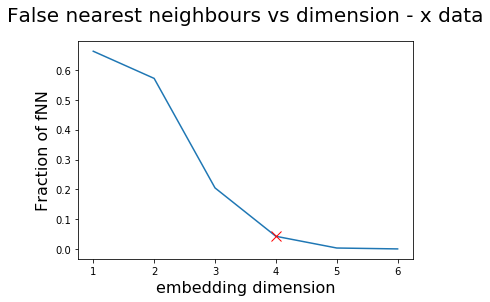

In [108]:
# False Nearest Neighbours for x data 

nFNN = []

for i in range (1,7):
    nFNN.append(false_nearest_neighbors(x_data,13,i) / len(x_data))

plt.plot(range(1,7),nFNN);
plt.plot(4,nFNN[3],'x', color='red', markersize=10)
plt.xlabel('embedding dimension', fontsize=16);
plt.ylabel('Fraction of fNN', fontsize=16);
plt.title('False nearest neighbours vs dimension - x data', fontsize=20, pad=20)

print(nFNN)

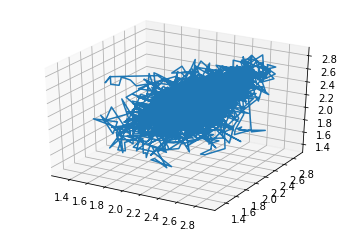

In [10]:
### Performing phase space reconstruction for x data 

embedded_x_final = takens_embedding(x_data, 13, 4)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(embedded_x_final[0,:], embedded_x_final[1,:], embedded_x_final[2,:])

In [11]:
### Function to compute the power specttrum of the phase space

def power_spectrum(data_array,time):

    fouriert_1 = sc.fft.rfftn(data_array, len(time))
    fourier_freq = sc.fft.rfftfreq(len(time), d = 0.02)
    power_spec = np.abs(fouriert_1)**2

    return power_spec, fourier_freq

The period of x data is 0.08002679169457466 seconds


Text(0, 0.5, 'Power')

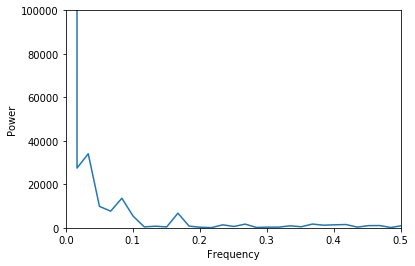

In [81]:
### Power spectrum for x data

power_spectrum_x = power_spectrum(x,t)
freq_x = power_spectrum_x[1]
power_x = power_spectrum_x[0]

# Finding index for the maxima on the graph
mean_freq_x = np.mean(freq_x)
period_x = 1/mean_freq_x

print('The period of x data is', + period_x,'seconds')

plt.plot(freq_x, power_x)
plt.xlim(0, 0.5)
plt.ylim(0, 1e5)
plt.xlabel('Frequency')
plt.ylabel('Power')

In [87]:
### Nearest neighbours for x data 

nearest_neighbours_x = NearestNeighbors(n_neighbors=200, algorithm='auto').fit(embedded_x_final.transpose())
distances_x, indices_x = nearest_neighbours_x.kneighbors(embedded_x_final.transpose())

print(indices_x[1])

[   1  124   92   72  664  188  112   74  126  138  272 2927  677  718
  670  113 2901  341  266  606  125  130  706  619 2888  651  100 2915
  263  333  717  620 2478  127 1892  111  658  690  103  684  683  668
  697 2914  730   24 2797  638  297  151  201  119  703   41   29   50
  678  308   14  149  121  267   85  295  276   99  616  106  271  911
  625  628   35 1905 1837 1889  736  472  115  615  704  645 2910  589
  605  727  473   86  698 1825  655  642  653  629 2727  602  657  641
  714  716  719  621   76  150 1900  332  122  593  284 2907  307   42
  200  476  685  666 2881  613   37 1902    0 2928  691  340  654 2925
  910  644  478  280  611 1812  139 1833   73   90  117  749  337 1820
  343 2792  693  331    3  632 2894  612  325  740  261  321   83  474
  141  175  723 2875  274 1804 2902  665 1824   89 2899 1299  461  631
  622  128  336 1836 1879  895  739  720   36  320   55  344  607 1883
   87  750 1838    9  464  726  763 2912  105 1849 2465 1862  669  137
    6 

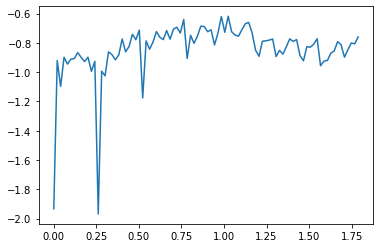

In [105]:
### Divergence for x data 

# Initialising arrays needed for divergence calculation
N = 90
separation_x1 = [ [] for i in range(N)]
logsep_x1 = [ [] for i in range(N)]
lags_x = []
xx_1 = [ [] for i in range(N)]
eps = period_x # Change this when period worked out from power spectrum    


# Extracting time differences between nearest neighbours
for i in range(N):
    xx_1[i] = indices_x[i] - i

xx_2 = np.array(xx_1)
times_x = xx_2*1e-3

for i in range(N):

    m_x = 0

    while np.abs(times_x[i][m_x]) < eps and m_x < 199:

        m_x = m_x + 1

    lags_x.append(times_x[i][m_x]) 

lags_x1 = np.array(lags_x)/1e-3
lags_x2 = lags_x1.astype(int)


# Calculating the divergence for Lyapunov exponent calculation
for i in range(0,N):
    
    for j in range(0,N):

        divv1 = np.sqrt((embedded_x_final[0,i+j+lags_x2[i]] - embedded_x_final[0,i+j])**2 + (embedded_x_final[1,i+j+lags_x2[i]] - embedded_x_final[1,i+j])**2 + (embedded_x_final[2,i+j+lags_x2[i]] - embedded_x_final[2,i+j])**2)
        separation_x1[j].append(divv1)


sep_x1 = np.array(separation_x1)

# Taking the logarithm of the divergence array
for i in range(N):

    logsep_x1[i] = np.log(sep_x1[i])

logsep_x1 = np.array(logsep_x1)

# Calculating the averaged ln(divergence)
av_log_div_x = np.mean(logsep_x1, axis = 1)

plt.plot(t[0:90], av_log_div_x)
